In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [8]:
class ImpactModel:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = pd.DataFrame()
        self.eta = None
        self.beta = None

    @staticmethod
    def read_pkl(path):
        with open(path, 'rb') as f:
            df = pd.read_pickle(f)
        return df

    @staticmethod
    def melt_df(df, var_name):
        melted_df = pd.melt(df.reset_index(), id_vars='index', value_vars=df.columns, var_name='Day',
                            value_name=var_name).rename(columns={'index': 'Stock'})
        return melted_df[var_name]

    def read_data(self):
        json_file_path = f"{self.filepath}/high_vol_days.json"

        with open(json_file_path, 'r') as file:
            high_vol_days = json.load(file)

        stocks = list(high_vol_days.keys())  # Or however you have your stocks defined
        days = range(65)  # Adjust based on your actual days

        high_vol_df = pd.DataFrame(True, index=stocks, columns=days)
        for stock, high_vol_days_list in high_vol_days.items():
            for day_idx in high_vol_days_list:
                if day_idx in high_vol_df.columns:
                    high_vol_df.at[stock, day_idx] = False

        value_imbalance = self.read_pkl(f"{self.filepath}/value_imbalance.pkl")
        volatility = self.read_pkl(f"{self.filepath}/Volatility.pkl")
        volatility = volatility[high_vol_df]
        daily_value = self.read_pkl(f"{self.filepath}/daily_values.pkl")
        temporary_impact = self.read_pkl(f"{self.filepath}/TemporaryImpact.pkl")

        X_long = self.melt_df(value_imbalance, 'X')
        V_long = self.melt_df(daily_value, 'V')
        h_long = self.melt_df(temporary_impact, 'h')
        sigma_long = self.melt_df(volatility, 'sigma')
        data = pd.DataFrame()
        data["X"] = np.abs(X_long)
        data["sign_X"] = np.sign(X_long)
        data["V"] = V_long.astype(float)
        data["h"] = h_long
        data["sigma"] = sigma_long.astype(float)
        data.dropna(axis=0, inplace=True)
        self.data["log_X"] = np.log(data["X"])
        self.data["sign_X"] = data["sign_X"]
        self.data["log_V"] = np.log(data["V"])
        self.data["log_sigma"] = np.log(data["sigma"])
        self.data["log_h"] = np.log(np.abs(data["h"]))
        self.data["sign_h"] = np.sign(data["h"])
        self.data.dropna(axis=0, inplace=True)
        self.log_data = pd.DataFrame()
        self.log_data["y"] = self.data["sign_h"] * data["sign_X"] * self.data["log_h"] - self.data["log_sigma"]
        #self.log_data["y"] = (self.data["log_h"] - self.data["log_sigma"])
        self.log_data["X"] = self.data["log_X"] - self.data["log_V"] - np.log(6/6.5)
        self.log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.log_data.dropna(axis=0, inplace=True)


    def regress(self):
        X = sm.add_constant(self.log_data["X"])
        y = self.log_data["y"]
        model = sm.OLS(y, X).fit()
        alpha = model.params[0]  # Intercept (alpha)
        beta = model.params[1]  # Slope(s) (beta values)
        eta = np.exp(alpha)
        print(f"eta = {eta}, beta = {beta}")
        #print(model.summary())
        self.eta = eta
        self.beta = beta
        return model

    def parametric_bootstrap(self, num_simulations=1000):
        alphas = []
        betas = []

        for _ in range(num_simulations):
            # Simulate data based on estimated parameters
            simulated_data = self.simulate_data()

            # Fit regression model on simulated data
            X_sim = sm.add_constant(simulated_data["X"])
            y_sim = simulated_data["y"]
            model_sim = sm.OLS(y_sim, X_sim).fit()

            # Append estimated parameters to lists
            alphas.append(model_sim.params.iloc[0])  # Use iloc indexer
            betas.append(model_sim.params.iloc[1])  # Use iloc indexer

        return alphas, betas

    def simulate_data(self):
        # Simulate data based on estimated parameters
        simulated_X = np.random.normal(loc=self.log_data["X"].mean(), scale=self.log_data["X"].std(), size=len(self.log_data))
        simulated_y = np.random.normal(loc=self.log_data["y"].mean(), scale=self.log_data["y"].std(), size=len(self.log_data))

        simulated_data = pd.DataFrame({"X": simulated_X, "y": simulated_y})

        return simulated_data

In [9]:
# Create an instance of the model and call methods
impact_model = ImpactModel('Impact-Model-Matrix')
impact_model.read_data()
model = impact_model.regress()
model.summary()

eta = 14.71926029012882, beta = -0.05243269737727729


C:\Users\Alex\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Alex\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     19.61
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           9.51e-06
Time:                        19:27:19   Log-Likelihood:                -70217.
No. Observations:               30377   AIC:                         1.404e+05
Df Residuals:                   30375   BIC:                         1.405e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6892      0.042     64.353      0.000       2.607       2.771
X             -0.0524      0.012     -4.429      0.000      -0.076      -0.029
==============================================================================
Omnibus:                      261.517   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.037
Skew:                           0.117   Prob(JB):                     8.15e-45
Kurtosis:                       2.675   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

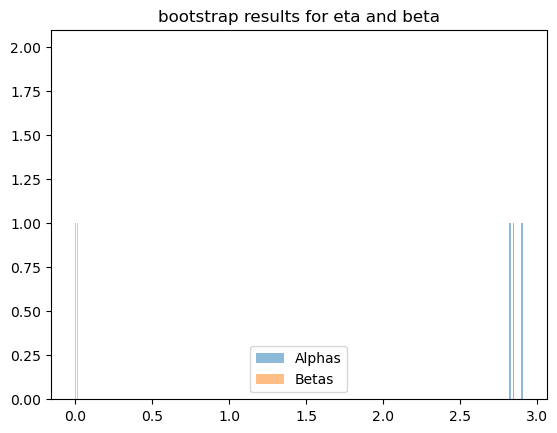

In [7]:
def plot_histograms(alphas, betas, filename='bootstrap_histogram.png'):
    plt.hist(alphas, bins=30, alpha=0.5, label='Alphas')
    plt.hist(betas, bins=30, alpha=0.5, label='Betas')
    plt.legend()
    plt.title("bootstrap results for eta and beta")
    plt.savefig(filename)  # Save the plot to a file
    plt.show()  # Close the plot to release memory

# Perform parametric bootstrap
alphas_bootstrap, betas_bootstrap = impact_model.parametric_bootstrap(num_simulations=10)

plot_histograms(alphas_bootstrap, betas_bootstrap, filename='bootstrap_histogram.png')

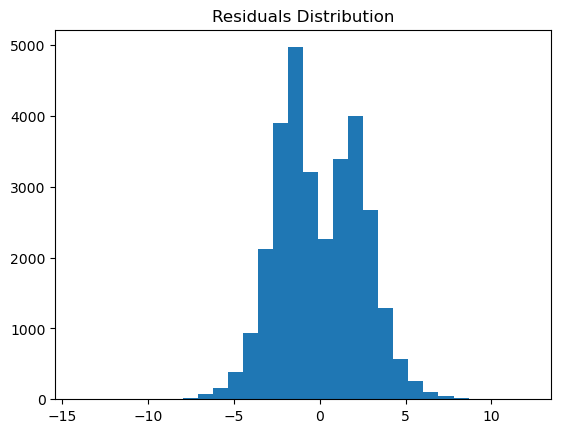

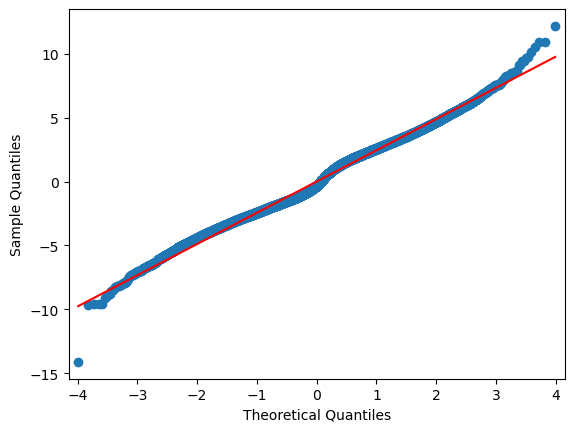

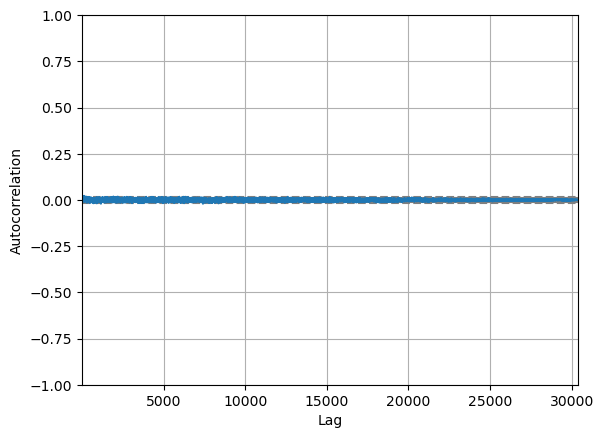

In [10]:
import matplotlib.pyplot as plt

residuals = model.resid

# Histogram for residuals
plt.hist(residuals, bins=30)
plt.title('Residuals Distribution')
plt.show()

# Q-Q plot for normality
sm.qqplot(residuals, line='s')
plt.show()

# Autocorrelation plot
pd.plotting.autocorrelation_plot(residuals)
plt.show()

In [12]:
from statsmodels.stats.diagnostic import het_white

white_stat, p_value, _, _ = het_white(residuals, model.model.exog)
heteroskedasticity = "not present" if p_value > 0.05 else "present"
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))
print(f"Heteroskedasticity is {heteroskedasticity} (White's test p-value: {p_value:.4f})")


{'Test Statistic': 196.55212832737814, 'Test Statistic p-value': 2.0856797786826423e-43, 'F-Statistic': 98.90632457146728, 'F-Test p-value': 1.5303704560136534e-43}
Heteroskedasticity is present (White's test p-value: 0.0000)
